# Dekompozycja szeregu

W trakcie budowy modelu przeprowadza się **dekompozycje szeregu czasowego** w zależności od przyjętych założeń.

**Oznaczenia**: $m_t$ - trend, $s_t$ - sezonowość, $\varepsilon_t$ - szum.

**Model addytywny** - wielkość wahań sezonowych lub wariancja danych wokół tendencji długoterminowej (trendu) nie zmienia się wraz z poziomem szeregu:
$$y_t = m_t + s_t + \varepsilon_t$$

**Model multiplikatywny** - amplituda wahań sezonowych lub wariancja danych proporcjonalna do poziomu szeregu:
$$y_t = m_t \cdot s_t \cdot \varepsilon_t$$


In [3]:
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from google.colab import files
src = list(files.upload().values())[0]
open('ts_utils.py','wb').write(src)

from ts_utils import check_time_series_stationary

import matplotlib.pyplot as plt
%matplotlib inline

Saving ts_utils.ipynb to ts_utils.ipynb


## Algorytm dekompozycji szeregu czasowego

1. Wyznaczamy oszacowany składnik trendu $\hat{m_t}$, wykorzystując np. metodę średniej ruchomej.
2. Oszacowany trend jest eliminowany z danych. Wyznaczamy szereg:

    a) dekompozycja addytywna: $y_t - \hat{m_t}$,
    
    b) dekompozycja multiplikatywna: $y_t/\hat{m_t}$.
    
3. Wyznaczamy indeksy sezonowe dla poszczególnych miesięcy, kwartałów, itd. Indeksy sezonowe są wyznaczane poprzez uśrednienie wartości szeregu z kroku 2 dla każdej jednostki czasu (np. miesiąc, kwartał) i wszystkich okresów (lat).
4. Standaryzujemy wskaźniki sezonowe, tak aby nie miały one wpływu na tendencję długoterminową.
5. Wyznaczamy reszty, usuwając trend i sezonowość

    a) dekompozycja addytywna: $\varepsilon_t = y_t - \hat{m_t} - \hat{s_t}$,
    
    b) dekompozycja multiplikatywna: $\varepsilon_t = y_t/\hat{m_t}/\hat{s_t}$.


## ***Zadanie 1

a) Przy użyciu metody średniej ruchomej oszacuj trend dla szeregu `southern`, wiedząc, że dla szeregu długości $n$, tzn. $Y_1, \ldots, Y_n$ estymacja średniej ruchomej w chwili $t$ jest postaci:
$$m(t)=\frac{1}{2q+1}\sum_{i=-q}^qY_{t-i},$$
gdzie $q$ jest rzędem średniej ruchomej (np. `convolution_filter` z `statsmodels.tsa.filters.filtertools`). 

Innymi słowy, aby wyznaczyć oszacowaną wartość trendu w chwili $t$, uśredniamy $q$ poprzedzających ten moment wartości i $q$ wartości następujących po tym momencie.

b) Następnie wyznacz indeksy sezonowe dla mięsięcy a następnie wystandaryzuj je przez średnią.

c) Oszacuj wartość reszt szeregu, sprawdź jego stacjonarność.

Załóż, że szereg `southern` jest szeregiem addytywnym.

In [4]:
southern = pd.read_csv('southern.csv', 
                 parse_dates=['Date'], index_col='Date')

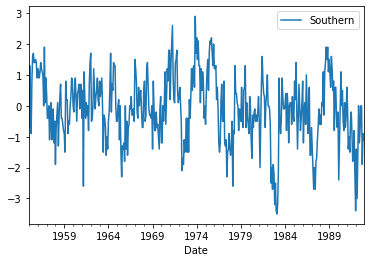

In [5]:
southern.plot()

#### Oszacowanie trendu

In [ ]:
from statsmodels.tsa.filters.filtertools import convolution_filter
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.filters.filtertools.convolution_filter.html

#### Oszacowanie sezonowości

In [ ]:
?numpy.tile

Object `numpy.tile` not found.


#### Oszacowanie elementu losowego i diagnostyka stacjonarności

## Zadanie 2
Dokonaj dekompozycji szeregu przy użyciu `seasonal_decompose` dla następujących danych:
- `southern`,
- `a10`,
- `AirPassengers`, 
- `sunspots`.

### `southern`

In [ ]:
southern = pd.read_csv('../data/southern.csv', 
                 parse_dates=['Date'], index_col='Date')

       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -6.1813
p-value             :     0.0000
--------------------------------



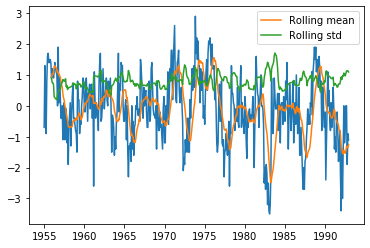

      Autocorrelation plot      
--------------------------------



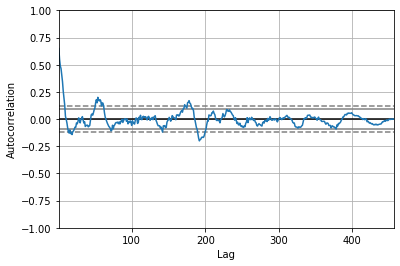

In [ ]:
check_time_series_stationary(southern.Southern)

In [ ]:
southern_dec= seasonal_decompose(southern, model='additive')

In [ ]:
southern_dec.trend # trend
southern_dec.seasonal # sezonowosc
southern_dec.resid.head(13) # reszty

,Southern
Date,
1955-01-01,NaN
1955-02-01,NaN
1955-03-01,NaN
1955-04-01,NaN
1955-05-01,NaN
1955-06-01,NaN
1955-07-01,0.695571
1955-08-01,0.375413
1955-09-01,0.254692


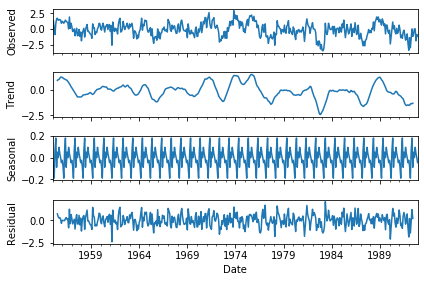

In [ ]:
southern_dec.plot()
plt.show()

       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -7.9992
p-value             :     0.0000
--------------------------------



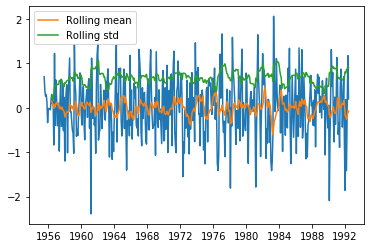

      Autocorrelation plot      
--------------------------------



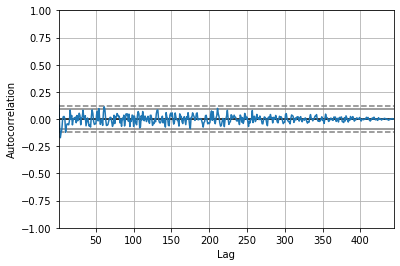

In [ ]:
check_time_series_stationary(southern_dec.resid.Southern.dropna())

### `a10`

In [ ]:
a10 = pd.read_csv('../data/a10.csv', parse_dates=['date'], index_col='date')
a10.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


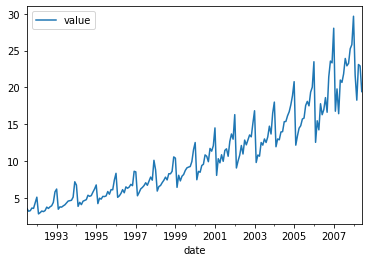

In [ ]:
a10.plot()

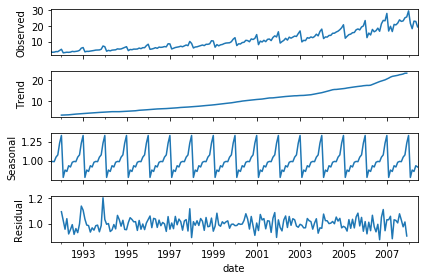

In [ ]:
a10_dec = seasonal_decompose(a10, model='multiplicative')
a10_dec.plot()
plt.show()

       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -5.9908
p-value             :     0.0000
--------------------------------



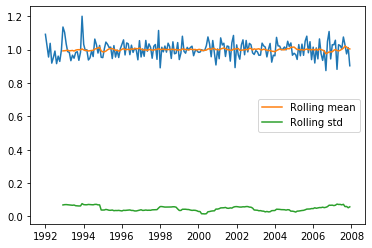

      Autocorrelation plot      
--------------------------------



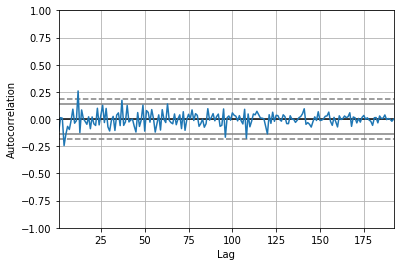

In [ ]:
check_time_series_stationary(a10_dec.resid.value.dropna())

### `AirPassengers`

### `sunspot` 
Time Series:
Start = 1700 
End = 1988 
Frequency = 1 

In [ ]:
sunspot = pd.read_csv('../data/sunspot.csv')
sunspot

,value
0,5.0
1,11.0
2,16.0
3,23.0
4,36.0
...,...
284,45.9
285,17.9
286,13.4
287,29.2


In [ ]:
sunspot.index = pd.date_range('1700', '1988', freq='AS')

In [ ]:
sunspot

,value
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
1984-01-01,45.9
1985-01-01,17.9
1986-01-01,13.4
1987-01-01,29.2


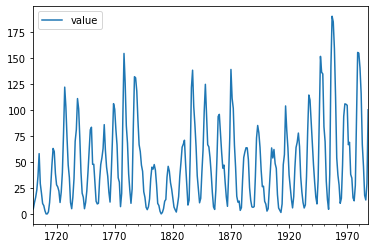

In [ ]:
sunspot.plot()

In [ ]:
?seasonal_decompose

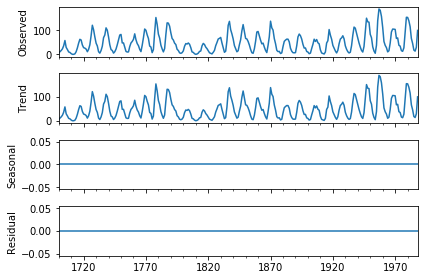

In [ ]:
sunspot_dec = seasonal_decompose(sunspot, model='additive')
sunspot_dec.plot()
plt.show()

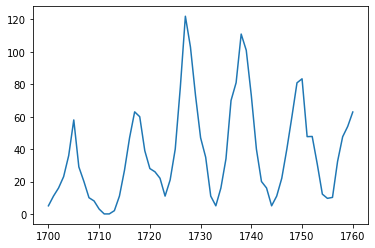

In [ ]:
plt.plot(sunspot[(sunspot.index >= '1700') & (sunspot.index <= '1760')])
plt.show()

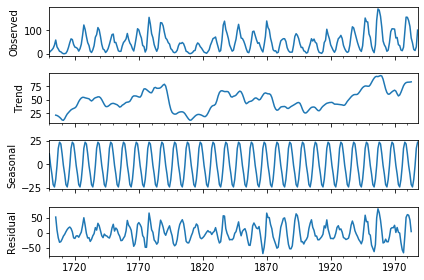

In [ ]:
sunspot_dec = seasonal_decompose(sunspot, model='additive', freq=10)
sunspot_dec.plot()
plt.show()

       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -9.7682
p-value             :     0.0000
--------------------------------



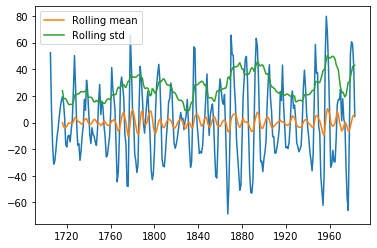

      Autocorrelation plot      
--------------------------------



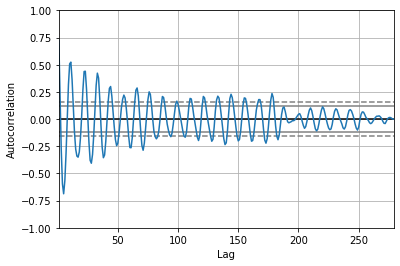

In [ ]:
check_time_series_stationary(sunspot_dec.resid.value.dropna())